In [1]:
# set to True if in colab
in_colab = True
floatType = 32
last_data_idx = -1

In [2]:
import tensorflow as tf
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
if floatType == 16:
    tf.keras.backend.set_floatx('float16')

Mounted at /content/drive


In [3]:
if in_colab:
    import sys
    data_dir = "/content/drive/MyDrive/data/"
    VOC2012_path = data_dir
    tracker_path = data_dir
    sys.path.append(tracker_path)
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
    checkpoint_filepath = data_dir + "fcn8_weights/"
else:
    data_dir = "../data/"
    VOC2012_path = data_dir + "VOCdevkit/"
    tracker_path = "../Tracking_SSD_ReID/"
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
    checkpoint_filepath = data_dir + "fcn8_weights/"

## Import model

In [4]:
from models.FCN8 import FCN8
model = FCN8(tracker_ssd_path = tracker_path, 
             ssd_weights_path = ssd_weights_path,
             floatType = floatType,
             n_classes=3)

## Prepare VOC2012 segmentation data

  1%|          | 22/2912 [00:00<00:13, 211.52it/s]


Loading images and annotations...


100%|██████████| 2912/2912 [00:12<00:00, 232.69it/s]



Convert to tensor...


  1%|▏         | 16/1085 [00:00<00:06, 157.74it/s]


Done
Images shape: (1085, 300, 300, 3), annotations shape: (1085, 300, 300, 1)
Reshape gt from (width,height,1) to (width,height,n_classes)


100%|██████████| 1085/1085 [00:01<00:00, 598.67it/s]


Images shape: (1085, 300, 300, 3), annotations shape: (1085, 300, 300, 3)
Examples:


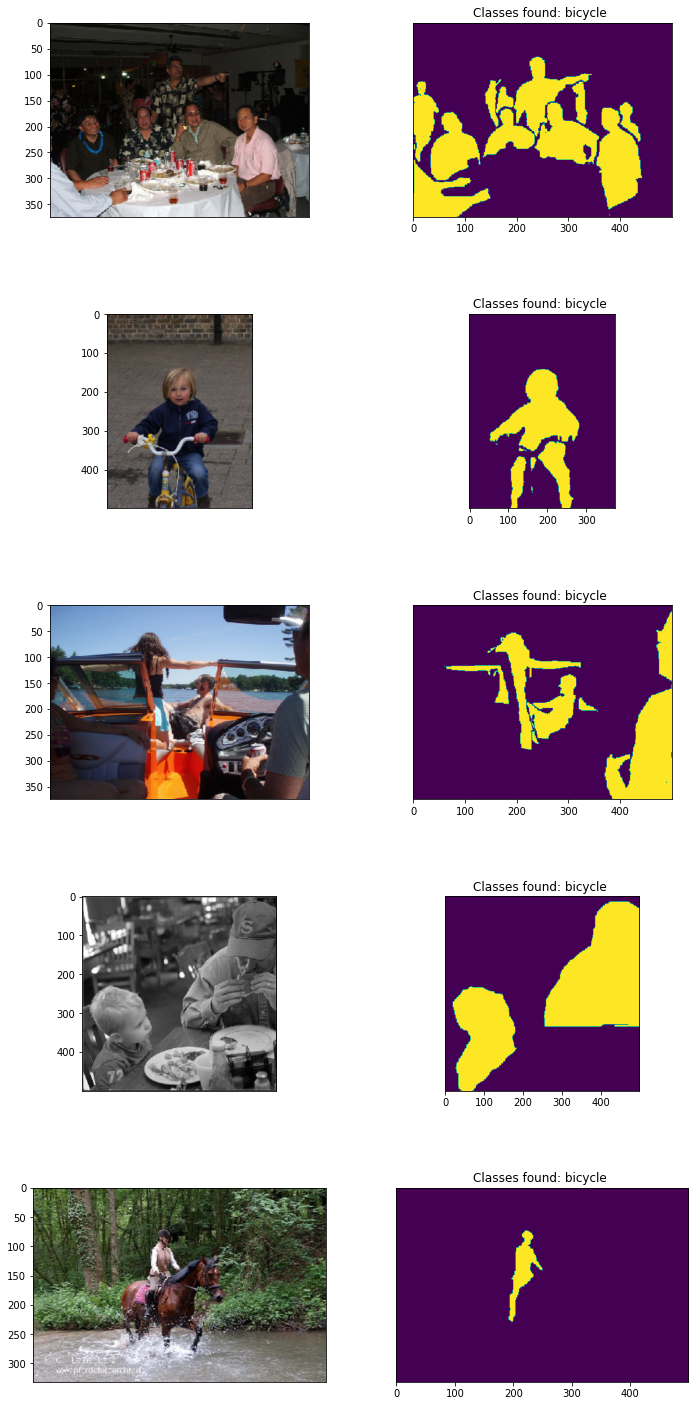

In [11]:
from data_management.VOC2012Manager import VOC2012Manager
input_shape=(300, 300, 3)

manager = VOC2012Manager(floatType = floatType, input_shape=input_shape)
targets = ["person", "dog"]
images, gt_annotations, filenames_png, original_shapes =\
    manager.load_and_prepare_data(
        VOC2012_path=VOC2012_path,
        n_samples_to_show=5,
        targets=targets,
        last_data_idx=last_data_idx)

In [12]:
train_ratio = 0.7
batch_size = 32
train_dataset, val_dataset = manager.tensorf2TFData(images, gt_annotations, train_ratio, batch_size)

In [7]:
# # verify train val shapes
# for train_img, train_annot in train_dataset:
#     break
# for val_img, val_annot in val_dataset:
#     break
# print(f"Train images shape: {train_img.shape}, train annotations shape: {train_annot.shape}")
# print(f"Val images shape: {val_img.shape}, Val annotations shape: {val_annot.shape}")

## Train model

In [13]:
sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [14]:
# number of training images
train_count = images.shape[0] * train_ratio

# number of validation images
validation_count = images.shape[0] * (1 - train_ratio)

epochs = 150

steps_per_epoch = train_count//batch_size
validation_steps = validation_count//batch_size

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [15]:
history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset, validation_steps=validation_steps,
                    epochs=epochs, callbacks=[model_checkpoint_callback])

Epoch 1/150
23/23 [==============================] - 28s 968ms/step - loss: 1.9360 - accuracy: 0.3276 - val_loss: 1.0847 - val_accuracy: 0.3990
Epoch 2/150
23/23 [==============================] - 25s 953ms/step - loss: 1.0072 - accuracy: 0.5111 - val_loss: 1.0390 - val_accuracy: 0.7169
Epoch 3/150
23/23 [==============================] - 21s 943ms/step - loss: 0.9239 - accuracy: 0.7745 - val_loss: 0.6272 - val_accuracy: 0.8181
Epoch 4/150
23/23 [==============================] - 22s 950ms/step - loss: 0.5944 - accuracy: 0.8287 - val_loss: 0.5341 - val_accuracy: 0.8353
Epoch 5/150
23/23 [==============================] - 22s 958ms/step - loss: 0.5795 - accuracy: 0.8194 - val_loss: 0.5571 - val_accuracy: 0.8199
Epoch 6/150
23/23 [==============================] - 22s 963ms/step - loss: 0.5726 - accuracy: 0.8146 - val_loss: 0.5545 - val_accuracy: 0.8147
Epoch 7/150
23/23 [==============================] - 22s 968ms/step - loss: 0.5401 - accuracy: 0.8279 - val_loss: 0.5188 - val_accuracy:

In [16]:
model.load_weights(checkpoint_filepath)

In [17]:
model.save(data_dir + "fcn8_final_weights/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/fcn8_final_weights/assets
